In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
%matplotlib notebook

def readHB(fname):
    
    global idx,ptrs,vals,rhs
    #fname='matrix.hb'
    f=open(fname,'r')
    
    
    '''
    Line 1 (A72,A8)
    Col. 1 - 72	Title (TITLE)
    Col. 73 - 80	Key (KEY)
    '''
    head = f.readline()
    title=head[:72].strip()
    key=head[72:].strip()

    '''
    Line 2:
    TOTCRD, integer, total number of data lines, (14 characters)
    PTRCRD, integer, number of data lines for pointers, (14 characters)
    INDCRD, integer, number of data lines for row or variable indices, (14 characters)
    VALCRD, integer, number of data lines for numerical values of matrix entries, (14 characters)
    RHSCRD, integer, number of data lines for right hand side vectors, starting guesses, and solutions, (14 characters)
    '''

    s = f.readline().split()
    totcrd = int(s[0])
    ptrcrd = int(s[1])
    indcrd = int(s[2])
    valcrd = int(s[3])
    rhscrd = int(s[4])

    '''
    Line 3:
    MXTYPE, matrix type (see table), (3 characters)
    blank space, (11 characters)
    NROW, integer, number of rows or variables, (14 characters)
    NCOL, integer, number of columns or elements, (14 characters)
    NNZERO, integer, number of row or variable indices. For "assembled" matrices, this is just the number of nonzero entries. (14 characters)
    NELTVL, integer, number of elemental matrix entries. For "assembled" matrices, this is 0. (14 characters)
    '''

    s = f.readline().split()
    mxtype=s[0]
    nrow=int(s[1])
    ncol=int(s[2])
    nnzero=int(s[3])
    neltvl=int(s[4])

    mxf=mxtype[0]
    mxsym=mxtype[1]
    mxasm=mxtype[2]

    '''
    Line 4:
    PTRFMT, FORTRAN I/O format for pointers, (16 characters)
    INDFMT, FORTRAN I/O format for row or variable indices, (16 characters)
    VALFMT, FORTRAN I/O format for matrix entries, (20 characters)
    RHSFMT, FORTRAN I/O format for right hand sides, initial guesses, and solutions, (20 characters)
    '''
    fmts = f.readline().split()


    '''
    Line 5: (only present if 0 < RHSCRD!)
    RHSTYP, describes the right hand side information, (3 characters)
    blank space, (11 characters)
    NRHS, integer, the number of right hand sides, (14 characters)
    NRHSIX, integer, number of row indices, (14 characters)
    '''
    if rhscrd>0:
        s = f.readline().split()
        rhstyp = s[0]
        nrhs=int(s[1])
        nrhsix=int(s[2])



    #    PTRCRD, integer, number of data lines for pointers, (14 characters)

    def readblock(f, num, nlines, dtype=int):
        res=np.zeros(num)
        k=0
        for i in range(nlines):
            s= f.readline().replace('D','E')
            fragment = np.fromstring(s,dtype=dtype,sep=' ')
            l=len(fragment)
            res[k:k+l]=fragment
            k+=l
        return res

    ptrs=readblock(f,nrow+1,ptrcrd)-1

    #INDCRD, integer, number of data lines for row or variable indices, (14 characters)
    idx=readblock(f,nnzero,indcrd)-1

    if mxf == 'C':
        raise ValueError('Complex numbers not supported for now')

    if mxf != 'P':
        #VALCRD, integer, number of data lines for numerical values of matrix entries, (14 characters)
        vals=readblock(f,nnzero,valcrd,dtype=np.float64)
    else:
        vals = np.ones(nnzero)


    #RHSCRD    
    if rhscrd>0:
        rhs = readblock(f,nrow,rhscrd,dtype=np.float64)    


    ''' 
    Each character of the MXTYPE variable specifies a separate fact about the matrix:

    R, C or P indicates that the matrix values are real, complex, or that only the pattern of nonzeroes is going to be supplied. Note that if complex arithmetic is specified, then any data vectors included in the file will also be assumed to be complex. FORTRAN I/O treats a complex number as a simple pair of real numbers. Thus, a line that records the single complex number 12+17i would look like
                12.0  17.0

    U, S, H, Z or R indicates that the matrix is symmetric, unsymmetric, Hermitian, skew symmetric, or rectangular. Each of these facts implies something about how the nonzero elements of the matrix are stored in the file.
    U: if the matrix is unsymmetric (and square), then every nonzero element of the matrix corresponds to an entry in the file.
    S: if the matrix is symmetric (which implies that it is square), (and which typically only occurs for real arithmetic), then half of the nonzero off-diagonal elements don't need to be stored in the file. A user need only specify the diagonal elements, and perhaps just those beneath the diagonal. A program reading the file must, correspondingly, assume that a value associated with one off-diagonal element should also be assigned to its corresponding transposed location.
    H: if the matrix is Hermitian, (which implies that it is square) (and which typically only occurs for complex arithmetic), then half of the nonzero off-diagonal elements don't need to be stored in the file. A user need only specify the diagonal elements, and perhaps just those beneath the diagonal. A program reading the file must, correspondingly, assume that a value associated with one off-diagonal element should also be used to assign a value to its corresponding transposed location.
    Z: if the matrix is skew symmetric, (which implies that it is square) (and which typically only occurs for real arithmetic), then the diagonal is zero, and only half of the nonzero offdiagonal elements need to be stored. (I believe that the Z code is only appropriate for a real matrix, and that the case of a skew Hermitian matrix is not provide for!)
    R: if the matrix is rectangular, then every nonzero element of the matrix must be stored. In effect, this is the same as the unsymmetric case.
    A indicates that the matrix is "assembled" (the typical case) while E indicates that the matrix is a finite element matrix that is going to be described as the "sum" of a set of smaller matrices.
    '''
    
    A=sp.csc_matrix((vals,idx,ptrs),shape=(nrow,ncol))

    if mxsym=='U':
        pass
    if mxsym=='S':
        D=sp.diags(A.diagonal())
        A = A+A.transpose()-D
    if mxsym=='Z':
        A = A-A.transpose()
    if mxsym=='H':
        D=sp.diags(A.diagonal())
        A = A+A.transpose().conj()-D
    print(rhscrd)
    f.close()
    return A
    


In [3]:
#A=readHB('matrix.hb')
#A=readHB('fs_680_2.rua')
#A=readHB('gr_30_30.rsa')
A=readHB('MATRIX.DAT')


0


In [6]:
A

<31920x31920 sparse matrix of type '<class 'numpy.float64'>'
	with 1924966 stored elements in Compressed Sparse Column format>

<IPython.core.display.Javascript object>


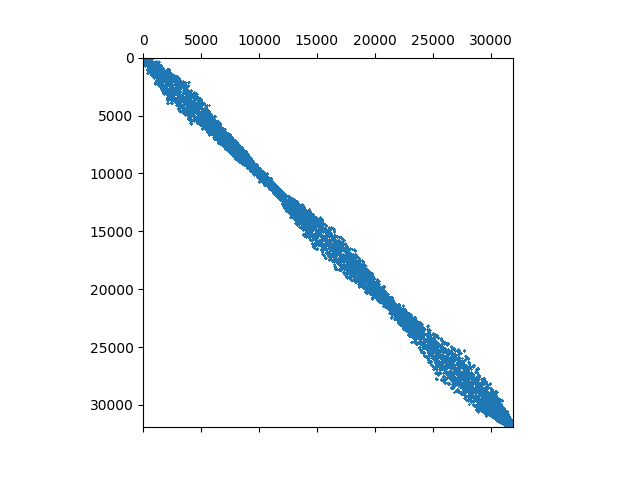

In [7]:
plt.spy(A,markersize=0.1)
plt.show()

In [8]:
#np.linalg.cond(A.toarray())

In [9]:
n=A.shape[0]

In [10]:
n

31920

In [11]:
A.nnz

1924966

In [12]:
idx

array([  0.00000000e+00,   1.00000000e+00,   3.00000000e+00, ...,
         3.19180000e+04,   3.19180000e+04,   3.19190000e+04])

In [13]:
rhs.max()

NameError: name 'rhs' is not defined

In [14]:
b=np.ones(n)

In [15]:
%time x0=spla.spsolve(A,b)

Wall time: 8.02 s


<IPython.core.display.Javascript object>


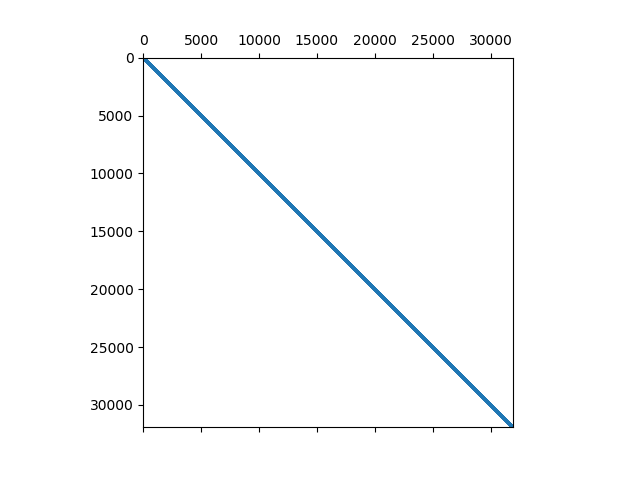

In [33]:
P=sp.diags(A.diagonal())
f=plt.figure(2)
plt.spy(P,markersize=0.5)


In [36]:
np.ones(5)/np.array([1,2,3,4,5])

array([ 1.        ,  0.5       ,  0.33333333,  0.25      ,  0.2       ])

In [16]:
D=A.diagonal()
def JacobiPrecond(x):
    return x/D
    
M = spla.LinearOperator((n, n), JacobiPrecond)

In [17]:
L=sp.tril(A).tocsr()

In [18]:
U=sp.triu(A).tocsr()

In [19]:
n=A.shape[0]

In [29]:
import time
t = time.time()
B = spla.spilu(A, drop_tol=1, fill_factor=2)
tilu = time.time() - t
print(B.L.nnz)
print(B.U.nnz)
Mz = lambda r: B.solve(r)

Minv = spla.LinearOperator(A.shape, Mz)

53511
53221


In [46]:
b=np.ones(n)

In [33]:
import numpy.linalg as la
i=0
def ff(x):
    global i
    print(i,la.norm(A.dot(x)-b)/la.norm(b))
    i+=1

In [39]:
i=0
%time spla.bicgstab(A,b,maxiter=1000,tol=1e-8,M=Minv,callback=ff)

0 18.5873978911
1 9.89747891379
2 7.3669695544
3 6.14007717793
4 12.7609178571
5 3.27462331362
6 2.74550100166
7 2.62652897369
8 2.56261707093
9 2.70913385399
10 2.25542375268
11 2.16438815671
12 2.08596952085
13 2.05271917472
14 2.03830124445
15 2.00519117105
16 2.0115852917
17 2.05906761559
18 1.85197145296
19 2.08339401735
20 1.77455778906
21 1.80099565015
22 3.40562646292
23 1.64647797515
24 1.61597270315
25 1.587421177
26 1.59042259347
27 1.61150822802
28 1.62391672596
29 1.64151294597
30 129.176379989
31 1.50080139855
32 1.48296107433
33 1.48278240783
34 1.4904697067
35 1.49644784259
36 1.50166190455
37 1.46762834186
38 1.46209000777
39 1.46655547664
40 1.46536384201
41 1.45350939178
42 1.45300857778
43 1.44939238483
44 1.45504236783
45 1.45254746465
46 1.45898089421
47 1.4725982029
48 1.47142199372
49 1.48156535866
50 1.49039381106
51 1.50425553279
52 1.51953834222
53 1.53118791657
54 1.54079272942
55 1.55428143819
56 1.57763445718
57 1.57445773874
58 1.59116527594
59 1.60462656

(array([  4.39913637e-04,   3.94411356e-04,  -6.04897390e-04, ...,
          9.35731241e-01,   2.34672618e+00,   1.84774664e+00]), -10)

-10

In [55]:
x-x0

NameError: name 'x0' is not defined

<IPython.core.display.Javascript object>


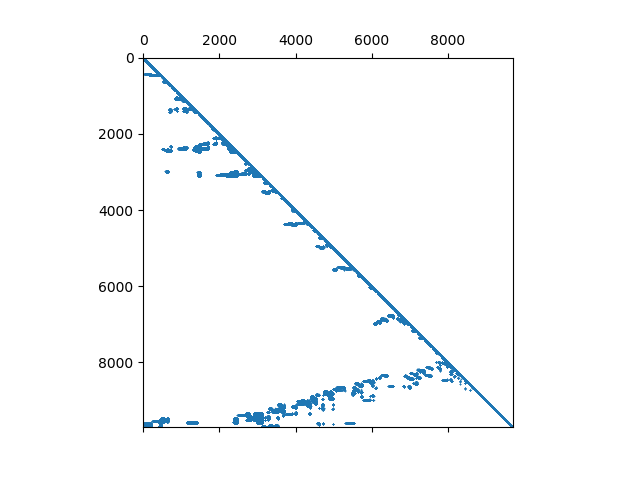

In [32]:
plt.figure()
plt.spy(B.L,markersize=0.2)

<IPython.core.display.Javascript object>


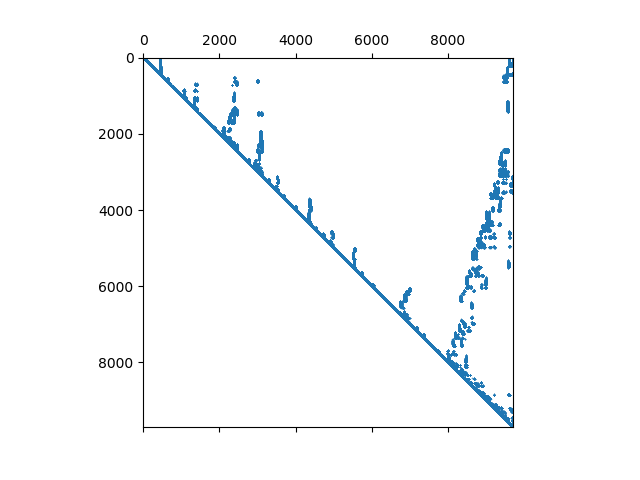

In [33]:
plt.figure()
plt.spy(B.U,markersize=0.2)

In [36]:
B.L.nnz

290905

In [102]:
%time x,iter = spla.cg(A,b,maxiter=1000,tol=1e-8, callback=ff)

0 4.42042414768
1 4.28953582944
2 4.17497631022
3 3.96565294747
4 3.85417436134
5 3.67433387054
6 3.53208040264
7 3.38363992807
8 3.22636334073
9 3.08681926002
10 2.93514267038
11 2.79047905723
12 2.64965470759
13 2.50197809115
14 2.36508626452
15 2.2221440324
16 2.08300440114
17 1.94731104342
18 1.80659199664
19 1.67477371856
20 1.5362898075
21 1.40484778073
22 1.27015080519
23 1.13875346619
24 1.28228465349
25 1.39802857912
26 1.38259067269
27 1.31202628785
28 1.2325456277
29 1.1909038745
30 1.11638387603
31 1.06425252003
32 1.00918575674
33 0.945919641324
34 0.900310306289
35 0.83877261963
36 0.790423852599
37 0.73810842753
38 0.686508272573
39 0.644404448181
40 0.605906415854
41 0.588698259331
42 0.595593084853
43 0.622872528652
44 0.655851469657
45 0.650785632961
46 0.608475049729
47 0.575635221442
48 0.5764081435
49 0.569313513604
50 0.514908092614
51 0.482432153397
52 0.455512138695
53 0.446168995154
54 0.418896463167
55 0.382395046297
56 0.366590579819
57 0.354076008061
58 0.32

In [103]:
%time spla.spsolve(A, b)

Wall time: 78.1 ms


array([  1.83333517e-06,   1.84413896e-06,   2.85484863e-06, ...,
         2.66993045e-06,   1.83333517e-06,   1.84413896e-06])

In [104]:
%time spla.spsolve_triangular(sp.triu(A).tocsr(), b, lower=False)

Wall time: 46.9 ms


array([  1.95157903e-07,   1.91727417e-07,   2.01730058e-07, ...,
         9.49981274e-08,   1.00806691e-07,   1.00806691e-07])

In [37]:
vals[0:10]

array([  2.41515111e+13,  -2.41507918e+13,   4.39507997e+05,
        -2.65118555e+05,   2.51218157e+06,  -4.77831911e+06,
        -7.42878006e+05,   4.77385484e+05,  -4.39507997e+05,
        -2.98956706e+06])

In [38]:
vals[-10:-1]

array([  7.14140199e+08,   7.14140199e+08,   7.14140199e+08,
         7.14140199e+08,   7.14140199e+08,   7.14140199e+08,
         7.14140199e+08,   7.14140199e+08,   7.14140199e+08])

https://relate.cs.illinois.edu/course/CS556-f16/file-version/c6f64e0aa732326b71b27641b6f6821d1942eb8a/demos/ILU%20preconditioning.html
